# EF notebook
Understanding previously formed companies.

*Author: Mikkel Dengsøe*

## Setup

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
import os
import ast

pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikkeld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
s = lambda x: 'https://www.joinef.com/actions/EF/portfolio/filter?page={}&sort=asc'.format(x)

In [192]:
FILENAME = 'cohort_data.csv'

In [193]:
def get_cohort_data(url_func, n=10):
    res = []
    for i in range(1, n):
        url = url_func(i)
        try:
            json = requests.get(url, allow_redirects=True).json()['result']
            res += json
        except Exception:
            print('{} out of range'.format(i))
    return pd.DataFrame(res)

In [194]:
def maybe_download(filename, n_cols=12):
    if os.path.isfile(filename):
        return pd.read_csv(filename, usecols=range(1,n_cols))
    else:
        data = get_cohort_data(s)
        data.to_csv(file_name)
        return data

In [195]:
cohort_data = maybe_download(FILENAME)

In [215]:
ais = ['ml', 'ai', 'artificial intelligence', 'machine learning']
phds = ['phd', 'doctor']
goog_apl_fb_amzn = ['google', 'deepmind', 'facebook', 'amazon', 'apple']
good_university = ['stanford', 'harvard', 'oxford', 'mit', 'cambridge', 'imperial', 'berkeley'] # not exhaustive!

In [197]:
def clean_description(ds):
    new_ds = ds.copy()
    new_ds = new_ds.str.lower
    new_ds = new_ds.replace(['.', ','], '')
    return new_ds  

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def match_tags(ds, terms):
    return [any([term in desc.split(' ') for term in terms]) for desc in ds] 

In [198]:
def clean_cohort_data(df):
    new_df = df.copy()
    new_df['projectLocation'] = new_df.projectLocation.apply(lambda x: ast.literal_eval(x)['label'])
    new_df['cohort'] = new_df.cohort.apply(lambda x: ''.join([d for d in ast.literal_eval(x)['label'] if d.isdigit()]))
    new_df['projectStatus'] = new_df.projectStatus.apply(lambda x: ast.literal_eval(x)['label'])
    new_df['sector'] = new_df.sector.apply(lambda x: ast.literal_eval(x)['label'])
    new_df['cleaned_description'] = new_df.projectDescription.str.lower()
    new_df['cleaned_description'] = new_df.cleaned_description.replace(['.', ','], '')
    new_df['cleaned_description'] = new_df.cleaned_description.apply(cleanhtml)
    new_df['number_of_founders'] = new_df.founders.apply(lambda x: len(ast.literal_eval(x)))
    new_df['ai'] = match_tags(new_df['cleaned_description'], ais)
    new_df['phds'] = match_tags(new_df['cleaned_description'], phds)
    new_df['goog_apl_fb_amzn'] = match_tags(new_df['cleaned_description'], goog_apl_fb_amzn)
    new_df['good_university'] = match_tags(new_df['cleaned_description'], good_university) 
    new_df['name'] = new_df['name'].str.upper()
    
    return new_df

cohort_clean_df = clean_cohort_data(cohort_data)  

### Location

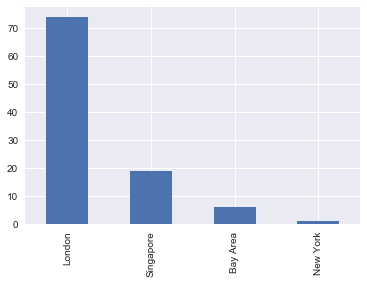

In [199]:
cohort_clean_df.projectLocation.value_counts().plot(kind="bar")

Most companies that were formed are based out of London followed by Singapore. Only a small handful are US-based

### Cohort

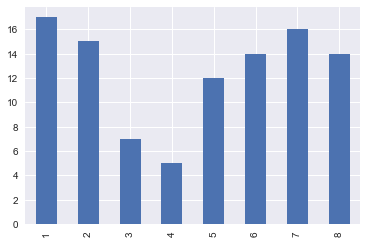

In [200]:
cohort_clean_df.cohort.value_counts().sort_index().plot(kind="bar")

Cohort 3 & 4 seems to have a low amount of formed companies. Apart from that it's fairly evenly distributed

### Sector

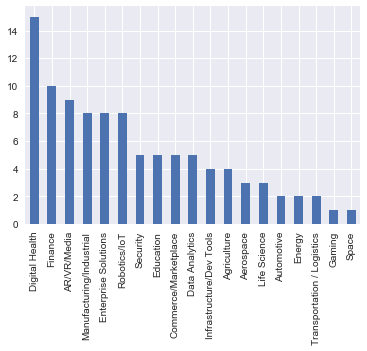

In [201]:
cohort_clean_df.sector.value_counts().plot(kind="bar")

Companies span a lot of different sectors with Digital Health taking the lead followed by Finance and AR/VR/Media. The landscape of companies that went on to raise $1M or more looks very diffferent though as we'll see later

### Founders

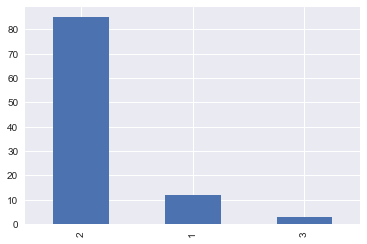

In [202]:
cohort_clean_df.number_of_founders.value_counts().plot(kind="bar")

2 seems to be the magic number for the amount of founders in companies that are formed

### Big words

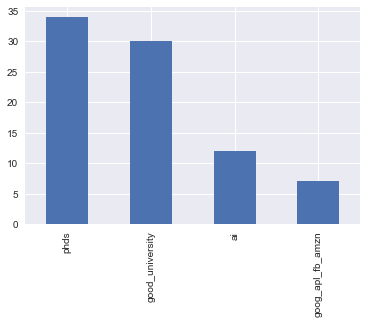

In [203]:
big_words = ['ai', 'phds', 'goog_apl_fb_amzn', 'good_university']

cohort_clean_df[big_words].sum().sort_values(ascending=False).plot(kind="bar")

The descriptive text for each company can help us understand the formed companies in depth. From this we see that
* One in three formed companies have one more or PhDs
* Almost one in three have a team member from a well known university
* 12 companies used the word ML or AI 
* 10 companies had members from Google, Apple, Amazon or Facebook

### Words

In [204]:
stop_words = set(stopwords.words('english'))

In [205]:
clean_concat_description = ' '.join(cohort_clean_df['cleaned_description'])    
wordcloud = WordCloud().generate(' '.join([w for w in clean_concat_description.split(' ') if w not in stop_words]))

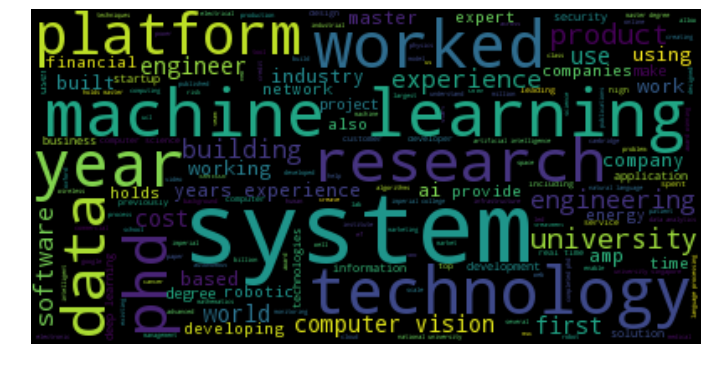

In [206]:
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the most frequntly mentioned words are machine learning, PhD, system, research, product, technology and engineering

### Funding
We can get some interesting funding data from crunchbase.com. It's worth noting that not all companies have funding data publicly available

In [207]:
funding_df = pd.read_csv('ef_data_crunchbase.csv')

In [208]:
CURRENCY_MAP = {
    '$': 1.00,
    '£': 1.40,
    '€': 1.24
}

SCALER_MAP = {
    'K': 1000.0,
    'M': 1000000.0
}

In [209]:
def align_currencies(x):
    if pd.isnull(x): return np.nan
    digits = x[1:-1]
    digits_usd = CURRENCY_MAP[x[0]] * float(digits)
    scaled_digits = SCALER_MAP[x[-1]] * float(digits_usd)  
    return scaled_digits

def clean_funding_data(df):
    new_df = df.copy()
    new_df['company_name'] = new_df['company_name'].str.upper()
    new_df['funding'] = new_df['funding'].apply(align_currencies)
    return new_df

In [210]:
clean_funding_df = clean_funding_data(funding_df)\
    .sort_values(by='funding', ascending=False)\
    .set_index('company_name')\
    .join(cohort_clean_df.set_index('name'))

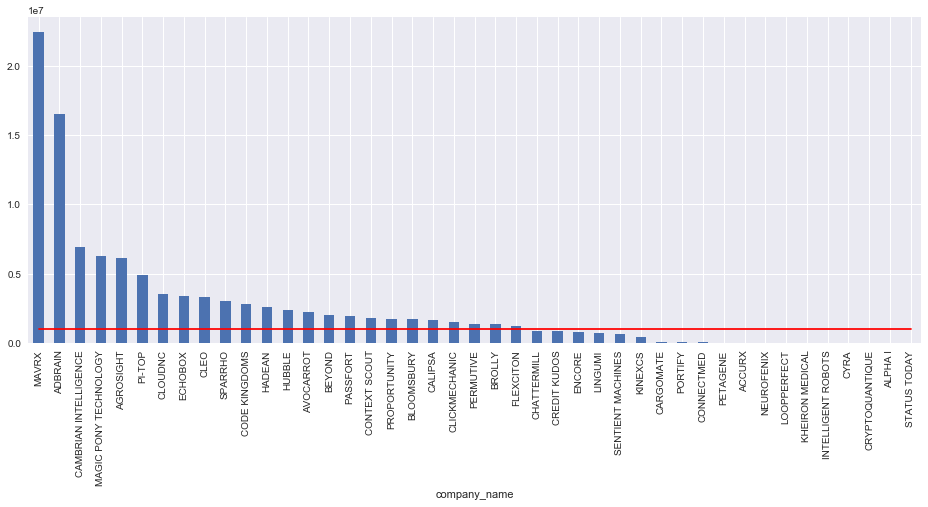

In [211]:
clean_funding_df[clean_funding_df.funding.notnull()].funding.plot(kind="bar", figsize=(16,6))
plt.plot([1000000 for i in range(len(clean_funding_df[clean_funding_df.funding.notnull()]))], color='r')

Out of the 100 companies that were incubated 24 have gone on to raise $1M or more from investors (above the red line)

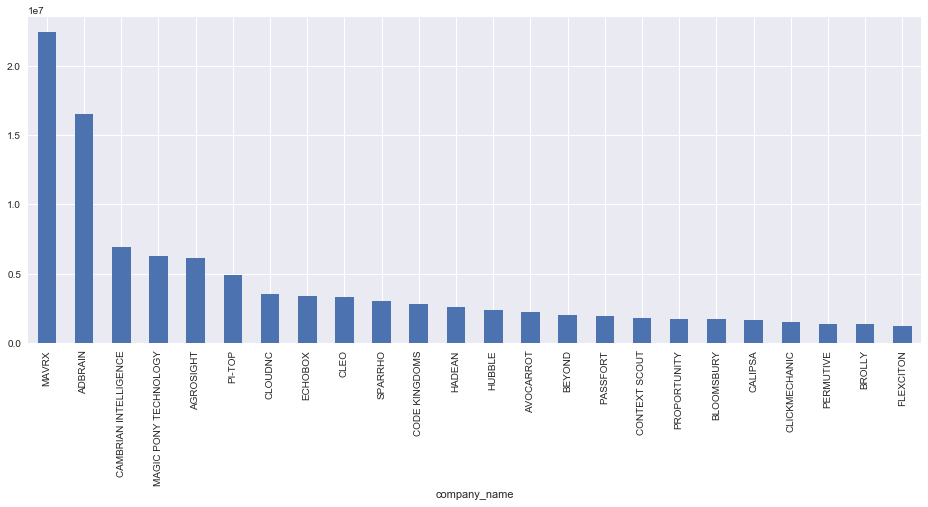

In [212]:
clean_funding_df[clean_funding_df.funding > 1000000].funding\
    .plot(kind="bar", figsize=(16,6))

zooming in on the > $1M companies

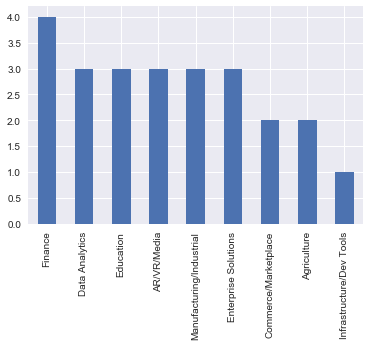

In [213]:
clean_funding_df[clean_funding_df.funding > 1000000].sector.value_counts().plot(kind='bar')

Looking closer at the companies that went on to raise more than $1M, popular sectors are Finance, Data Analytics, Education, Manufacturing and Enterprise

### Acquisitions

In [214]:
clean_funding_df[clean_funding_df.acquisition.notnull()]['acquisition']

company_name
ADBRAIN                  Y    
MAGIC PONY TECHNOLOGY    $150M
AVOCARROT                $20M 
REPRESENT                Y    
Name: acquisition, dtype: object

4 EF companies have been acquired. The prices for AdBrain and Represent are undisclosed